In [66]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("UserStory8_IntentClassification").getOrCreate()

data_path = "C:\\Users\\jagadeesh02.TRN\\Desktop\\Project Details\\enriched_df6.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

df = df.select(
    col("User Query"),
    col("Intent Detected"),
    col("Response Time (ms)").alias("response_time"),
    col("User Sentiment").alias("sentiment"),
    col("Device Type").alias("device_type")
).na.drop()
df.show()


+--------------------+--------------------+-------------+---------+-----------+
|          User Query|     Intent Detected|response_time|sentiment|device_type|
+--------------------+--------------------+-------------+---------+-----------+
|What is your pred...|    Financial Advice|          150|  Neutral|     Tablet|
|What is your pred...|         Price Check|          155| Positive|    Desktop|
|   Any news on Gold?|    Stock Prediction|          160| Positive|     Mobile|
|Should I buy or s...|     Strategy Advice|          165| Positive|     Mobile|
|What's the trend ...|     Strategy Advice|          170| Positive|    Desktop|
|Should I buy or s...|      Forex Analysis|          175| Positive|     Mobile|
|    Analysis of Oil?|         Price Check|          180| Positive|    Desktop|
|What's the price ...|Cryptocurrency Up...|          185| Negative|     Tablet|
|Should I buy or s...|     Market Analysis|          190| Positive|     Tablet|
|Give me an update...| Investment Planni

In [68]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DebugLabelIndexing").getOrCreate()


In [69]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer, VectorAssembler
#Tokenizer: Splits raw text into individual words (tokens) for processing.
# StopWordsRemover: Removes common words (e.g., “the”, “is”) that don't add much meaning.
# HashingTF: Converts the list of words into a fixed-length numerical feature vector using the hashing trick.
# IDF (Inverse Document Frequency): Scales down frequent terms and highlights important words to create TF-IDF features.
# StringIndexer: Converts categorical string labels into numeric indices for machine learning algorithms.
# VectorAssembler: Combines multiple feature columns into a single feature vector column, required by ML models.
from pyspark.ml.classification import DecisionTreeClassifier
# DecisionTreeClassifier: A supervised machine learning algorithm used for classification tasks. 
# It builds a decision tree model to predict the class label based on input features.
from pyspark.ml import Pipeline
# Pipeline: A utility to chain multiple data processing stages and ML algorithms sequentially.
# It simplifies workflow by applying all transformations and model training/testing in a single, reusable pipeline.

# Convert the target column 'Intent Category' (string) into numeric labels for classification
label_indexer = StringIndexer(inputCol="Intent Detected", outputCol="label")

# Tokenize the 'User Query' text into individual words (tokens)
tokenizer = Tokenizer(inputCol="User Query", outputCol="words")

# Remove common stop words (like "the", "is", "and") from tokenized words to reduce noise
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Convert the filtered words into raw term frequency feature vectors using hashing trick
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=1000)

# Compute the inverse document frequency (IDF) to scale down frequent words, generating TF-IDF features
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

# Convert categorical feature 'device_type' into numeric indices
device_indexer = StringIndexer(inputCol="device_type", outputCol="device_index")

# Combine all features (TF-IDF vector, response time, sentiment score, and device index) into a single feature vector
assembler = VectorAssembler(
    inputCols=["tfidf_features", "response_time", "sentiment", "device_index"],
    outputCol="features"
)

# Initialize Decision Tree Classifier for predicting the user intent label
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Create a Pipeline to chain all transformations and the classifier into a single workflow
# Why use Pipeline?
from pyspark.ml.feature import (
    Tokenizer, StopWordsRemover, HashingTF, IDF, 
    StringIndexer, VectorAssembler
)
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

# =========================
# 1. Label Encoding
# =========================
# Convert the target column 'Intent Detected' (string) into numeric labels for classification
label_indexer = StringIndexer(inputCol="Intent Detected", outputCol="label")

# =========================
# 2. Text Processing
# =========================
# Tokenize the 'User Query' text into individual words (tokens)
tokenizer = Tokenizer(inputCol="User Query", outputCol="words")

# Remove common stop words (like "the", "is", "and") to reduce noise
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Convert filtered words into raw term frequency vectors using the hashing trick
hashing_tf = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=1000)

# Compute inverse document frequency to scale down frequent words and produce TF-IDF features
idf = IDF(inputCol="raw_features", outputCol="tfidf_features")

# =========================
# 3. Categorical Feature Encoding
# =========================
# Convert string-based 'device_type' into numeric indices
device_indexer = StringIndexer(inputCol="device_type", outputCol="device_index")

# Convert string-based 'sentiment' into numeric indices
sentiment_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index")

# =========================
# 4. Feature Assembly
# =========================
# Combine numeric features into a single vector column for ML model input
assembler = VectorAssembler(
    inputCols=["tfidf_features", "response_time", "sentiment_index", "device_index"],
    outputCol="features"
)

# =========================
# 5. Classifier
# =========================
# Initialize a Decision Tree Classifier to predict user intent category
dt_classifier = DecisionTreeClassifier(featuresCol="features", labelCol="label1")

# =========================
# 6. Pipeline Construction
# =========================
# Pipeline allows chaining of all preprocessing and model steps into a single workflow
pipeline = Pipeline(stages=[
    label_indexer,        # Convert target labels to numeric
    tokenizer,            # Tokenize user queries
    stopwords_remover,    # Remove stop words
    hashing_tf,           # Generate term frequency vectors
    idf,                  # Compute TF-IDF
    device_indexer,       # Encode device type
    sentiment_indexer,    # Encode user sentiment
    assembler,            # Assemble all features into a single vector
    dt_classifier          # Apply decision tree classifier
])

# =========================
# 📌 Why use a Pipeline?
# =========================
# - Simplifies the ML workflow by chaining preprocessing and training steps
# - Ensures consistent transformation on training and test data
# - Reduces risk of errors and improves reproducibility
# - Easier to maintain, tune, and extend


In [70]:
# Reinitialize Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("SafeRun_LabelEncoding").getOrCreate()

# Import after restart
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col

# Load data again
df = spark.read.csv("C:\\Users\\jagadeesh02.TRN\\Desktop\\Project Details\\enriched_df6.csv", header=True, inferSchema=True)

# Label Encoding
label_indexer = StringIndexer(inputCol="Intent Detected", outputCol="label1")
df = label_indexer.fit(df).transform(df)
df.select("Intent Detected", "label1").show(5)


+----------------+------+
| Intent Detected|label1|
+----------------+------+
|Financial Advice|   5.0|
|     Price Check|   7.0|
|Stock Prediction|   6.0|
| Strategy Advice|   1.0|
| Strategy Advice|   1.0|
+----------------+------+
only showing top 5 rows



In [107]:
# 2️⃣ Tokenizer
tokenizer = Tokenizer(inputCol="User Query", outputCol="words2")
df = tokenizer.transform(df)
df.select("User Query", "words2").show(5, truncate=False)

+----------------------------------+-----------------------------------------+
|User Query                        |words2                                   |
+----------------------------------+-----------------------------------------+
|What is your prediction for Bonds?|[what, is, your, prediction, for, bonds?]|
|What is your prediction for Forex?|[what, is, your, prediction, for, forex?]|
|Any news on Gold?                 |[any, news, on, gold?]                   |
|Should I buy or sell WTI?         |[should, i, buy, or, sell, wti?]         |
|What's the trend with Tesla?      |[what's, the, trend, with, tesla?]       |
+----------------------------------+-----------------------------------------+
only showing top 5 rows



In [109]:
# 3️⃣ Stop Words Removal
stopwords_remover = StopWordsRemover(inputCol="words2", outputCol="filtered_words2")
df = stopwords_remover.transform(df)
df.select("words2", "filtered_words2").show(5, truncate=False)

+-----------------------------------------+--------------------+
|words2                                   |filtered_words2     |
+-----------------------------------------+--------------------+
|[what, is, your, prediction, for, bonds?]|[prediction, bonds?]|
|[what, is, your, prediction, for, forex?]|[prediction, forex?]|
|[any, news, on, gold?]                   |[news, gold?]       |
|[should, i, buy, or, sell, wti?]         |[buy, sell, wti?]   |
|[what's, the, trend, with, tesla?]       |[trend, tesla?]     |
+-----------------------------------------+--------------------+
only showing top 5 rows



In [111]:
# 4️⃣ HashingTF
hashing_tf = HashingTF(inputCol="filtered_words2", outputCol="raw_features3", numFeatures=1000)
df = hashing_tf.transform(df)
df.select("filtered_words2", "raw_features3").show(5, truncate=False)

+--------------------+---------------------------------+
|filtered_words2     |raw_features3                    |
+--------------------+---------------------------------+
|[prediction, bonds?]|(1000,[117,427],[1.0,1.0])       |
|[prediction, forex?]|(1000,[373,427],[1.0,1.0])       |
|[news, gold?]       |(1000,[126,433],[1.0,1.0])       |
|[buy, sell, wti?]   |(1000,[80,485,773],[1.0,1.0,1.0])|
|[trend, tesla?]     |(1000,[9,836],[1.0,1.0])         |
+--------------------+---------------------------------+
only showing top 5 rows



In [112]:
# 5️⃣ IDF
idf = IDF(inputCol="raw_features3", outputCol="tfidf_features3")
idf_model = idf.fit(df)
df = idf_model.transform(df)
df.select("raw_features3", "tfidf_features3").show(5, truncate=False)

+---------------------------------+------------------------------------------------------------------------------+
|raw_features3                    |tfidf_features3                                                               |
+---------------------------------+------------------------------------------------------------------------------+
|(1000,[117,427],[1.0,1.0])       |(1000,[117,427],[3.353406717825807,2.4899141715186226])                       |
|(1000,[373,427],[1.0,1.0])       |(1000,[373,427],[3.3823942546990593,2.4899141715186226])                      |
|(1000,[126,433],[1.0,1.0])       |(1000,[126,433],[3.058607177605162,2.5020355320509675])                       |
|(1000,[80,485,773],[1.0,1.0,1.0])|(1000,[80,485,773],[2.5020355320509675,2.5020355320509675,3.5765502691400166])|
|(1000,[9,836],[1.0,1.0])         |(1000,[9,836],[2.5520459526256287,3.245193133185574])                         |
+---------------------------------+---------------------------------------------

In [113]:
from pyspark.sql.functions import col

# Rename 'Device Type' to 'device_type'
df = df.withColumnRenamed("Device Type", "device_type")

In [115]:
device_indexer = StringIndexer(inputCol="device_type", outputCol="device_index1")
df = device_indexer.fit(df).transform(df)
df.select("device_type", "device_index1").show(5)


+-----------+-------------+
|device_type|device_index1|
+-----------+-------------+
|     Tablet|          2.0|
|    Desktop|          1.0|
|     Mobile|          0.0|
|     Mobile|          0.0|
|    Desktop|          1.0|
+-----------+-------------+
only showing top 5 rows



In [116]:
df = df.withColumnRenamed("User Sentiment", "sentiment")
# or check available column names:
print(df.columns)


['Interaction ID', 'Timestamp', 'User Query', 'Intent Detected', 'Bot Response', 'response_time', 'Prediction Accuracy (%)', 'Entity Extraction Accuracy (%)', 'sentiment', 'User Feedback', 'Conversation Success', 'User ID', 'User Type', 'Region', 'device_type', 'Account Age (months)', 'Is Premium', 'error_type', 'error_type_index', 'error_type_index1', 'error_type_index2', 'cluster', 'Response Time (ms)_df', 'Prediction Accuracy (%)_df', 'label1', 'words', 'filtered_words', 'raw_features1', 'filtered_words1', 'raw_features2', 'tfidf_features1', 'tfidf_features2', 'device_index', 'sentiment_index1', 'words1', 'words2', 'filtered_words2', 'raw_features3', 'tfidf_features3', 'device_index1']


In [118]:
#Drop or fill nulls before indexing
df = df.na.drop(subset=["sentiment"])  # Drop rows with null sentiment
# OR
df = df.fillna({"sentiment": "unknown"})  # Replace nulls with a default label

#Inconsistent Data Types or Corrupt Rows
df.select("sentiment").distinct()

#Recommended Safe Flow Before Indexing

# Check column names first
print(df.columns)

# Rename column if needed
df = df.withColumnRenamed("User Sentiment", "sentiment")

# Check for distinct values
df.select("sentiment").distinct().show()

# Handle nulls (drop or fill)
df = df.na.drop(subset=["sentiment"])

# Now apply StringIndexer
from pyspark.ml.feature import StringIndexer

sentiment_indexer = StringIndexer(inputCol="sentiment", outputCol="sentiment_index2")
df = sentiment_indexer.fit(df).transform(df)

# Show the result
df.select("sentiment", "sentiment_index2").show(10)



['Interaction ID', 'Timestamp', 'User Query', 'Intent Detected', 'Bot Response', 'response_time', 'Prediction Accuracy (%)', 'Entity Extraction Accuracy (%)', 'sentiment', 'User Feedback', 'Conversation Success', 'User ID', 'User Type', 'Region', 'device_type', 'Account Age (months)', 'Is Premium', 'error_type', 'error_type_index', 'error_type_index1', 'error_type_index2', 'cluster', 'Response Time (ms)_df', 'Prediction Accuracy (%)_df', 'label1', 'words', 'filtered_words', 'raw_features1', 'filtered_words1', 'raw_features2', 'tfidf_features1', 'tfidf_features2', 'device_index', 'sentiment_index1', 'words1', 'words2', 'filtered_words2', 'raw_features3', 'tfidf_features3', 'device_index1']
+---------+
|sentiment|
+---------+
|  Neutral|
| Positive|
| Negative|
+---------+

+---------+----------------+
|sentiment|sentiment_index2|
+---------+----------------+
|  Neutral|             2.0|
| Positive|             0.0|
| Positive|             0.0|
| Positive|             0.0|
| Positive|   

In [119]:
df.printSchema()


root
 |-- Interaction ID: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- User Query: string (nullable = true)
 |-- Intent Detected: string (nullable = true)
 |-- Bot Response: string (nullable = true)
 |-- response_time: integer (nullable = true)
 |-- Prediction Accuracy (%): integer (nullable = true)
 |-- Entity Extraction Accuracy (%): integer (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- User Feedback: string (nullable = true)
 |-- Conversation Success: string (nullable = true)
 |-- User ID: string (nullable = true)
 |-- User Type: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- Account Age (months): integer (nullable = true)
 |-- Is Premium: boolean (nullable = true)
 |-- error_type: string (nullable = true)
 |-- error_type_index: double (nullable = true)
 |-- error_type_index1: double (nullable = true)
 |-- error_type_index2: double (nullable = true)
 |-- cluster: integer 

In [120]:
# 8️⃣ Assemble Features
assembler = VectorAssembler(
    inputCols=["tfidf_features2", "Response Time (ms)_df", "sentiment_index1", "device_index"],
    outputCol="features2"
)
df = assembler.transform(df)
df.select("features2").show(5, truncate=False)

# Now df is ready with 'features' and 'label'
# You can continue with classifier training using this transformed DataFrame

+-----------------------------------------------------------------------------------------+
|features2                                                                                |
+-----------------------------------------------------------------------------------------+
|(1003,[117,427,1000,1001,1002],[3.353406717825807,2.4899141715186226,150.0,2.0,2.0])     |
|(1003,[373,427,1000,1002],[3.3823942546990593,2.4899141715186226,155.0,1.0])             |
|(1003,[126,433,1000],[3.058607177605162,2.5020355320509675,160.0])                       |
|(1003,[80,485,773,1000],[2.5020355320509675,2.5020355320509675,3.5765502691400166,165.0])|
|(1003,[9,836,1000,1002],[2.5520459526256287,3.245193133185574,170.0,1.0])                |
+-----------------------------------------------------------------------------------------+
only showing top 5 rows



In [121]:
df.printSchema()

root
 |-- Interaction ID: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)
 |-- User Query: string (nullable = true)
 |-- Intent Detected: string (nullable = true)
 |-- Bot Response: string (nullable = true)
 |-- response_time: integer (nullable = true)
 |-- Prediction Accuracy (%): integer (nullable = true)
 |-- Entity Extraction Accuracy (%): integer (nullable = true)
 |-- sentiment: string (nullable = false)
 |-- User Feedback: string (nullable = true)
 |-- Conversation Success: string (nullable = true)
 |-- User ID: string (nullable = true)
 |-- User Type: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- Account Age (months): integer (nullable = true)
 |-- Is Premium: boolean (nullable = true)
 |-- error_type: string (nullable = true)
 |-- error_type_index: double (nullable = true)
 |-- error_type_index1: double (nullable = true)
 |-- error_type_index2: double (nullable = true)
 |-- cluster: integer 

In [122]:
# Rename columns to match pipeline expectations
df = df.withColumnRenamed("Response Time (ms)", "response_time") \
       .withColumnRenamed("User Sentiment", "sentiment") \
       .withColumnRenamed("Device Type", "device_type")


In [125]:
# Drop the existing 'features' column to avoid conflict with pipeline
df = df.drop("words")


In [128]:
df = df.drop("filtered_words")

In [130]:
df = df.drop("device_index")

In [131]:
# Split data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)


In [132]:

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy = {accuracy:.4f}")

dt_model = model.stages[-1]
print("Feature Importances:", dt_model.featureImportances)




Test Accuracy = 0.0741
Feature Importances: (1003,[82,86,117,126,138,173,186,296,348,678,748,855,931,973,1000,1001,1002],[0.054227662332836254,0.028923458055957703,0.03464329422022482,0.06828895925735902,0.03732636133836806,0.03755080743269037,0.05784854118009035,0.036336461617844505,0.04160680562731941,0.02953475483121245,0.07763492551628141,0.04664930207051117,0.03442807916385951,0.042186446544304264,0.261181928032716,0.044142248068319116,0.06748996471010571])


In [133]:
#Format the accuracy and print it clearly.....for better clearityof the output
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

# Evaluate model accuracy
accuracy = evaluator.evaluate(predictions)

# Print results with clean formatting
print("\n" + "="*40)
print("🎯 MODEL EVALUATION RESULTS")
print("="*40)
print(f"✅ Test Set Accuracy: {accuracy:.4f}")
print("="*40 + "\n")



🎯 MODEL EVALUATION RESULTS
✅ Test Set Accuracy: 0.0741



In [134]:
#### Access trained DecisionTree model from the pipeline###
dt_model = model.stages[-1]

# Display feature importances in a readable format
importances = dt_model.featureImportances

print("🌟 Feature Importances (sparse vector format):")
print(importances)

# If you want to see them as a list
importance_list = importances.toArray().tolist()
print("\n🧠 Feature Importances as List:")
for idx, importance in enumerate(importance_list):
    print(f"Feature {idx + 1}: {importance:.6f}")


🌟 Feature Importances (sparse vector format):
(1003,[82,86,117,126,138,173,186,296,348,678,748,855,931,973,1000,1001,1002],[0.054227662332836254,0.028923458055957703,0.03464329422022482,0.06828895925735902,0.03732636133836806,0.03755080743269037,0.05784854118009035,0.036336461617844505,0.04160680562731941,0.02953475483121245,0.07763492551628141,0.04664930207051117,0.03442807916385951,0.042186446544304264,0.261181928032716,0.044142248068319116,0.06748996471010571])

🧠 Feature Importances as List:
Feature 1: 0.000000
Feature 2: 0.000000
Feature 3: 0.000000
Feature 4: 0.000000
Feature 5: 0.000000
Feature 6: 0.000000
Feature 7: 0.000000
Feature 8: 0.000000
Feature 9: 0.000000
Feature 10: 0.000000
Feature 11: 0.000000
Feature 12: 0.000000
Feature 13: 0.000000
Feature 14: 0.000000
Feature 15: 0.000000
Feature 16: 0.000000
Feature 17: 0.000000
Feature 18: 0.000000
Feature 19: 0.000000
Feature 20: 0.000000
Feature 21: 0.000000
Feature 22: 0.000000
Feature 23: 0.000000
Feature 24: 0.000000
Feat

C:\Users\jagadeesh02.TRN\AppData\Local\Temp\ipykernel_22716\1172768503.py:26: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\jagadeesh02.TRN\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


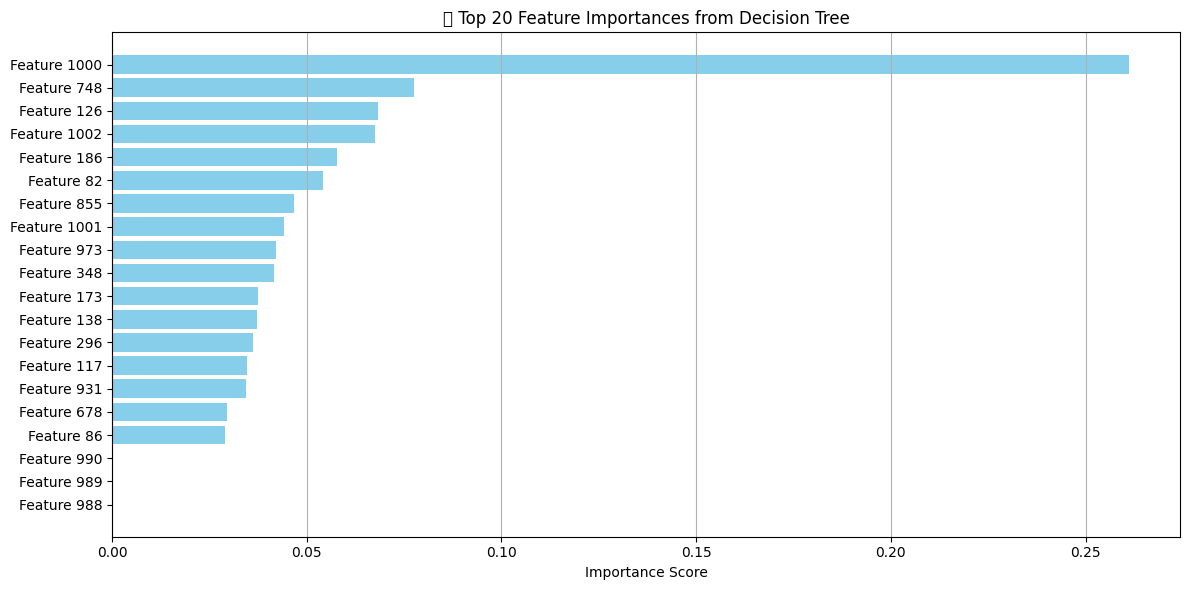

In [135]:
###Visualization of Feature Importances###
import matplotlib.pyplot as plt
import numpy as np

# Access trained DecisionTree model from the pipeline
dt_model = model.stages[-1]

# Extract feature importances as array
importances = dt_model.featureImportances.toArray()

# Sort importances in descending order and get top N
top_n = 20
indices = np.argsort(importances)[::-1][:top_n]  # Indices of top N features
top_importances = importances[indices]

# Generate feature labels (adjust if you know exact names of non-TFIDF features)
feature_names = [f"Feature {i}" for i in indices]

# Create bar plot
plt.figure(figsize=(12, 6))
plt.barh(range(top_n), top_importances[::-1], align='center', color='skyblue')
plt.yticks(range(top_n), [feature_names[i] for i in range(top_n)][::-1])
plt.xlabel("Importance Score")
plt.title("🔍 Top 20 Feature Importances from Decision Tree")
plt.grid(axis="x")
plt.tight_layout()
plt.show()


In [137]:
# Example:
# Let's say last 3 features are:
# 1000 - response_time
# 1001 - sentiment_index
# 1002 - device_index

custom_names = [f"TF-IDF {i}" if i < 1000 else
                "response_time" if i == 1000 else
                "sentiment_index" if i == 1001 else
                "device_index" if i == 1002 else
                f"Unknown {i}"
                for i in range(len(importances))]

# Then map this into the sorted selection:
feature_names = [custom_names[i] for i in indices]
# Print feature names and their importance scores
print("\nTop Features with Importances:")
for name, importance in zip(feature_names, top_importances):
    print(f"{name}: {importance:.6f}")



Top Features with Importances:
response_time: 0.261182
TF-IDF 748: 0.077635
TF-IDF 126: 0.068289
device_index: 0.067490
TF-IDF 186: 0.057849
TF-IDF 82: 0.054228
TF-IDF 855: 0.046649
sentiment_index: 0.044142
TF-IDF 973: 0.042186
TF-IDF 348: 0.041607
TF-IDF 173: 0.037551
TF-IDF 138: 0.037326
TF-IDF 296: 0.036336
TF-IDF 117: 0.034643
TF-IDF 931: 0.034428
TF-IDF 678: 0.029535
TF-IDF 86: 0.028923
TF-IDF 990: 0.000000
TF-IDF 989: 0.000000
TF-IDF 988: 0.000000


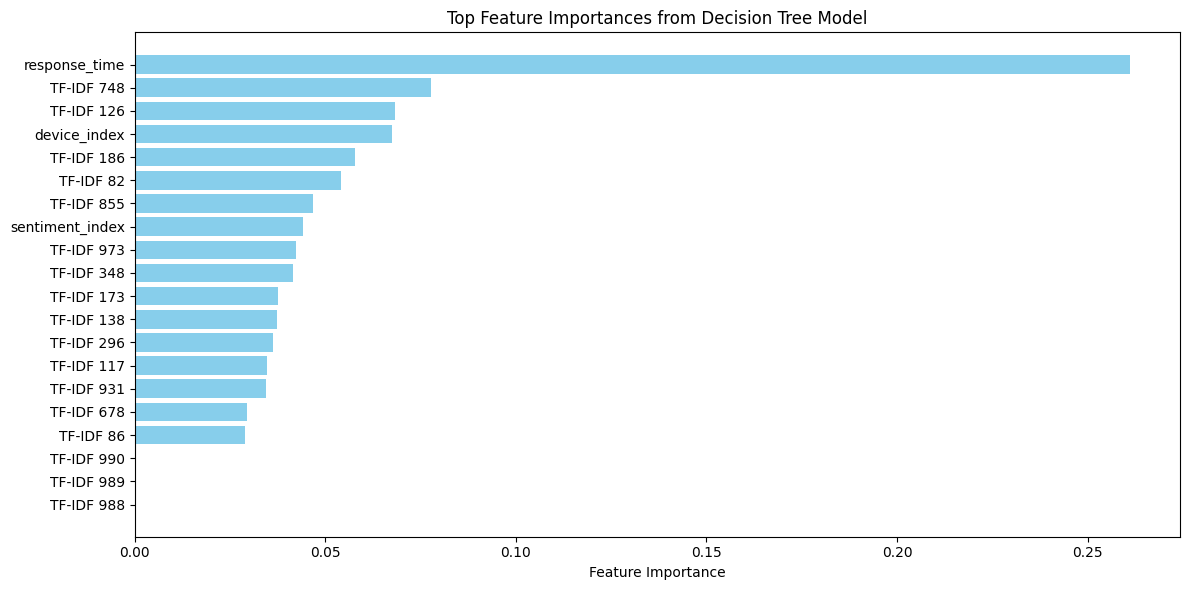

In [138]:
### bar chart visualization ###
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# feature_names (list of strings)
# top_importances (numpy array or list of floats)

plt.figure(figsize=(12, 6))
y_pos = np.arange(len(feature_names))

plt.barh(y_pos, top_importances, color='skyblue')
plt.yticks(y_pos, feature_names)
plt.gca().invert_yaxis()  # Highest importance on top

plt.xlabel('Feature Importance')
plt.title('Top Feature Importances from Decision Tree Model')
plt.tight_layout()
plt.show()


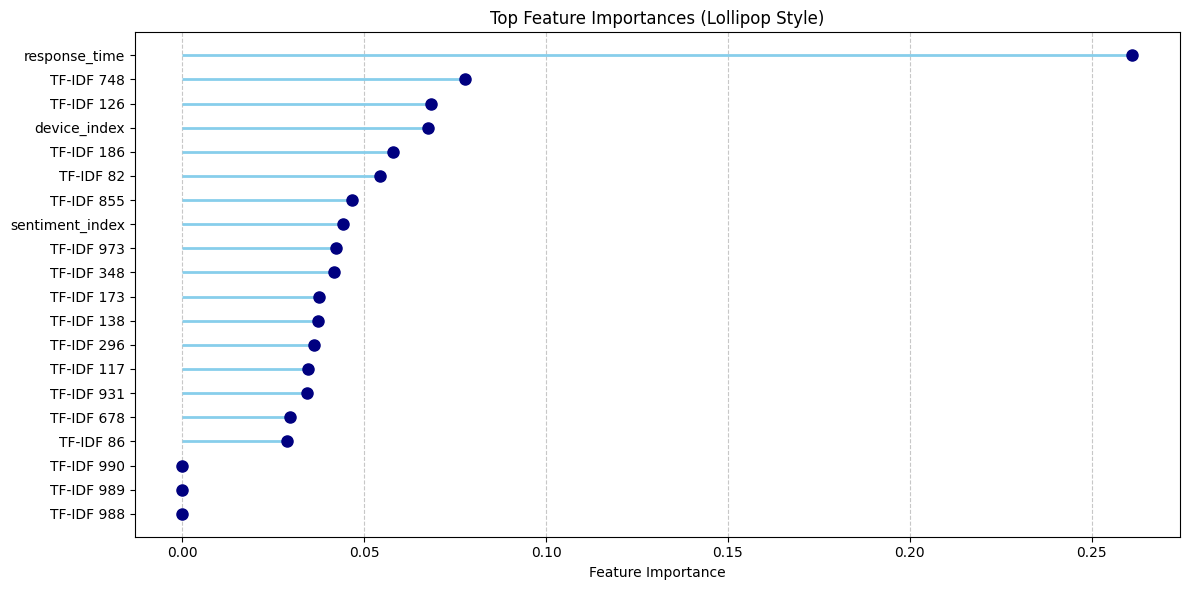

In [139]:
###Horizontal Lollipop Chart###

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
y_pos = np.arange(len(feature_names))

# Plot lines
plt.hlines(y=y_pos, xmin=0, xmax=top_importances, color='skyblue', linewidth=2)
# Plot dots
plt.plot(top_importances, y_pos, "o", markersize=8, color='navy')

plt.yticks(y_pos, feature_names)
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top Feature Importances (Lollipop Style)")
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


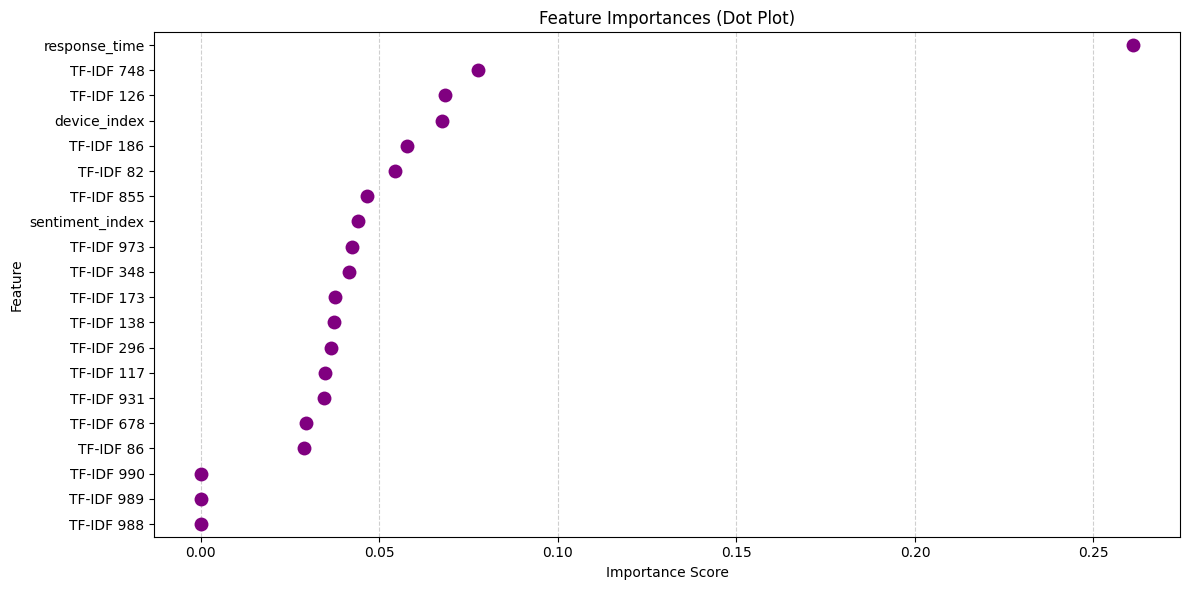

In [140]:
### Seaborn Strip Plot ###
import seaborn as sns
import pandas as pd

# Prepare DataFrame
feature_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": top_importances
})

plt.figure(figsize=(12, 6))
sns.stripplot(data=feature_df, x="Importance", y="Feature", size=10, color='purple', orient='h')

plt.title("Feature Importances (Dot Plot)")
plt.xlabel("Importance Score")
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


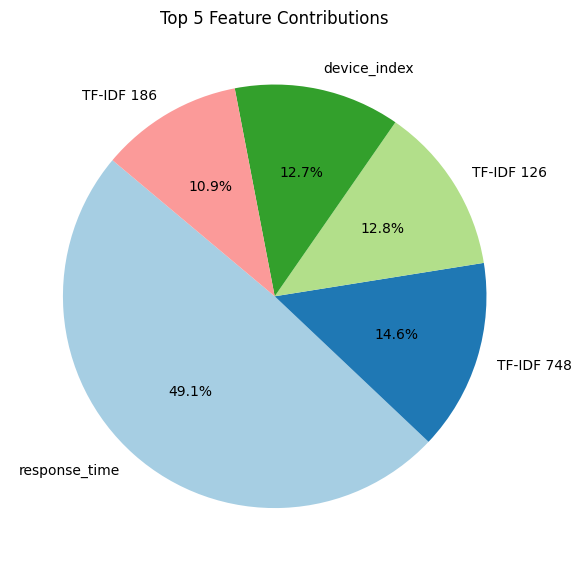

In [142]:
###PieChart###
import matplotlib.pyplot as plt

# Take top 5 for clarity
top_n = 5
labels = feature_names[:top_n]
sizes = top_importances[:top_n]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140, colors=plt.cm.Paired.colors)
plt.title("Top 5 Feature Contributions")
plt.tight_layout()
plt.show()
